<a href="https://colab.research.google.com/github/Jrocha424/Stock-Market-Data-Preprocessing-/blob/master/Preprocessing%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
api_key="MRUL85B38MKFBH"

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import datetime
import tensorflow as tf
from alpha_vantage.timeseries import TimeSeries
ts=TimeSeries(key=api_key, output_format='pandas')

In [17]:
class DataGenerator():
    def __init__(self, interval, outputsize):
        self. interval= interval
        self.outputsize=outputsize   
        
    def raw_data(self, symbol):
        data, _=ts.get_intraday(symbol, interval=self.interval, outputsize=self.outputsize) 
        return  data 
    
    def Normalization(self, symbol, split_fraction):       
        data, _=ts.get_intraday(symbol, interval=self.interval, outputsize=self.outputsize)
        data=data[::-1].reset_index()     
        date_time=pd.to_datetime(data.pop('date'))
        training=data[:int(len(data)*split_fraction)]   
        validation=data[int(len(data)*split_fraction):]
        training_norm= (training - training.mean())/ training.std()
        validation_norm= (validation - training.mean())/ training.std()
        return  training_norm, validation_norm, date_time 

In [9]:
time_1hr_full=DataGenerator(interval='60min', outputsize='full')
time_30min_full=DataGenerator(interval='30min', outputsize='full')
time_5min_full=DataGenerator(interval='5min', outputsize='full')
time_15min_full=DataGenerator(interval='15min', outputsize='full')
time_1min_full=DataGenerator(interval='1min', outputsize='full')

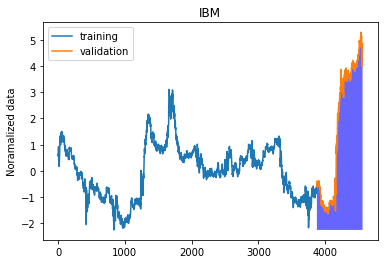

In [10]:

training, validation,date_time = time_1min_full.Normalization("IBM", 0.85)
plt.plot(training['1. open'], label='training')
plt.plot(validation['1. open'], label='validation')
plt.title('IBM')
plt.ylabel('Noramalized data')
plt.legend()
plt.fill_between(validation["1. open"].index, validation["1. open"], min(training["1. open"]), facecolor='b', alpha=0.6)

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               training=training, label_columns=None):
      self.input_width=input_width 
      self.label_width=label_width
      self.shift=shift
      self.label_columns=label_columns
      self.total_window_size = input_width + shift
      self.columns_indices={name:i for i,name in enumerate(training.columns)}
      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]
      self.label_indices = np.arange(self.total_window_size)[self.total_window_size - self.label_width: ]
      
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.total_window_size - self.label_width:, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.columns_indices[name]] for name in self.label_columns],
        axis=-1)
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels



In [20]:
  WindowGenerator.split_window = split_window

In [21]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
  ds = ds.map(self.split_window)
  return ds


WindowGenerator.make_dataset = make_dataset

In [22]:

w12 = WindowGenerator(input_width=6, label_width=6, shift=6, training=training,
                     label_columns=['4. close'])

print(w12)

Total window size: 12
Input indices: [0 1 2 3 4 5]
Label indices: [ 6  7  8  9 10 11]
Label column name(s): ['4. close']


In [23]:
for example_inputs, example_labels in w12.make_dataset(validation).take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 5)
Labels shape (batch, time, features): (32, 6, 1)
